In [74]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
from torch.utils.data import Dataset, DataLoader

# data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [75]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [76]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-57-29.net.auckland.ac.nz


In [77]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 20

### Dataloader

In [78]:
class GWDataset(Dataset):
    def __init__(self, x, y):
        # convert to numpy array
        self.original_parameters = y
        self.parameters = self.original_parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1]))

        x = np.transpose(x)
        self.original_data = x
        self.data = self.original_data
        self.augmented_data = np.empty(shape = (self.data.shape[0], 0))

    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 25, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(10, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 203

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            # idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            # signal_2 = self.data[:, idx_2]
            # signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            augmented_signal = self.window_warping_augmentation(signal_1)
            # augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just sample parameters for now, haven't figured out a way to augment them to make consistent with signal augmentation
            augmented_parameter = self.parameters[idx_1, :]
            augmented_parameter = augmented_parameter.reshape(1, -1)

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print(self.data.shape)
        print(self.parameters.shape)

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        # pad signals with edge values to be length 512
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = self.standardize(signal_padded)

        return signal_standardized, parameter

In [79]:
x = pd.read_csv("../data/gw-raw-data/richers_1764.csv")
y = pd.read_csv("../data/gw-raw-data/richers_1764_parameters.csv")

# remove erroneous signals and select only beta_IC_b as label
keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
y = y.iloc[keep_signals_idx,:]
# select continuous beta_IC_b values for now
y = y[['beta1_IC_b']].astype('float32')
# bin labels to get discretised data
# y['beta1_IC_b_bins'] = pd.qcut(y['beta1_IC_b'], q=10, labels=False)
# y = y[['beta1_IC_b_bins']].astype('float32')
# convert to numpy array
y = y.values

# drop corresponding signals which have erroneous parameter values
x = x.iloc[:,keep_signals_idx]
x = x.values

# only transpore x due to compatibility issues with train_test_split
x = np.transpose(x)

# Split the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=manualSeed)

train_data = GWDataset(x_train, y_train)
test_data = GWDataset(x_test, y_test)

# split the total augmentated signal count to 6000 to match distribution of GAN training dataset
train_data.augmentation(4800)
test_data.augmentation(1200)

train_data.calc_stats()
test_data.calc_stats()

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(407, 4800)
(4800, 1)
(407, 1200)
(1200, 1)
Dataset mean:  -0.27173269679772144
Dataset std:  32.635964620123545
Dataset scaling factor (to match noise in generator):  5
Dataset mean:  -0.29293954344194534
Dataset std:  31.076075107727952
Dataset scaling factor (to match noise in generator):  5


[0.01580689]
[0.19653916]
[0.20336781]
[0.01557414]
[0.1278897]
[0.08168656]
[0.17538698]
[0.00894201]
[0.19833954]
[0.01576025]
[0.03372351]
[0.1691123]
[0.00700701]
[0.12061112]
[0.01628586]
[0.01895099]


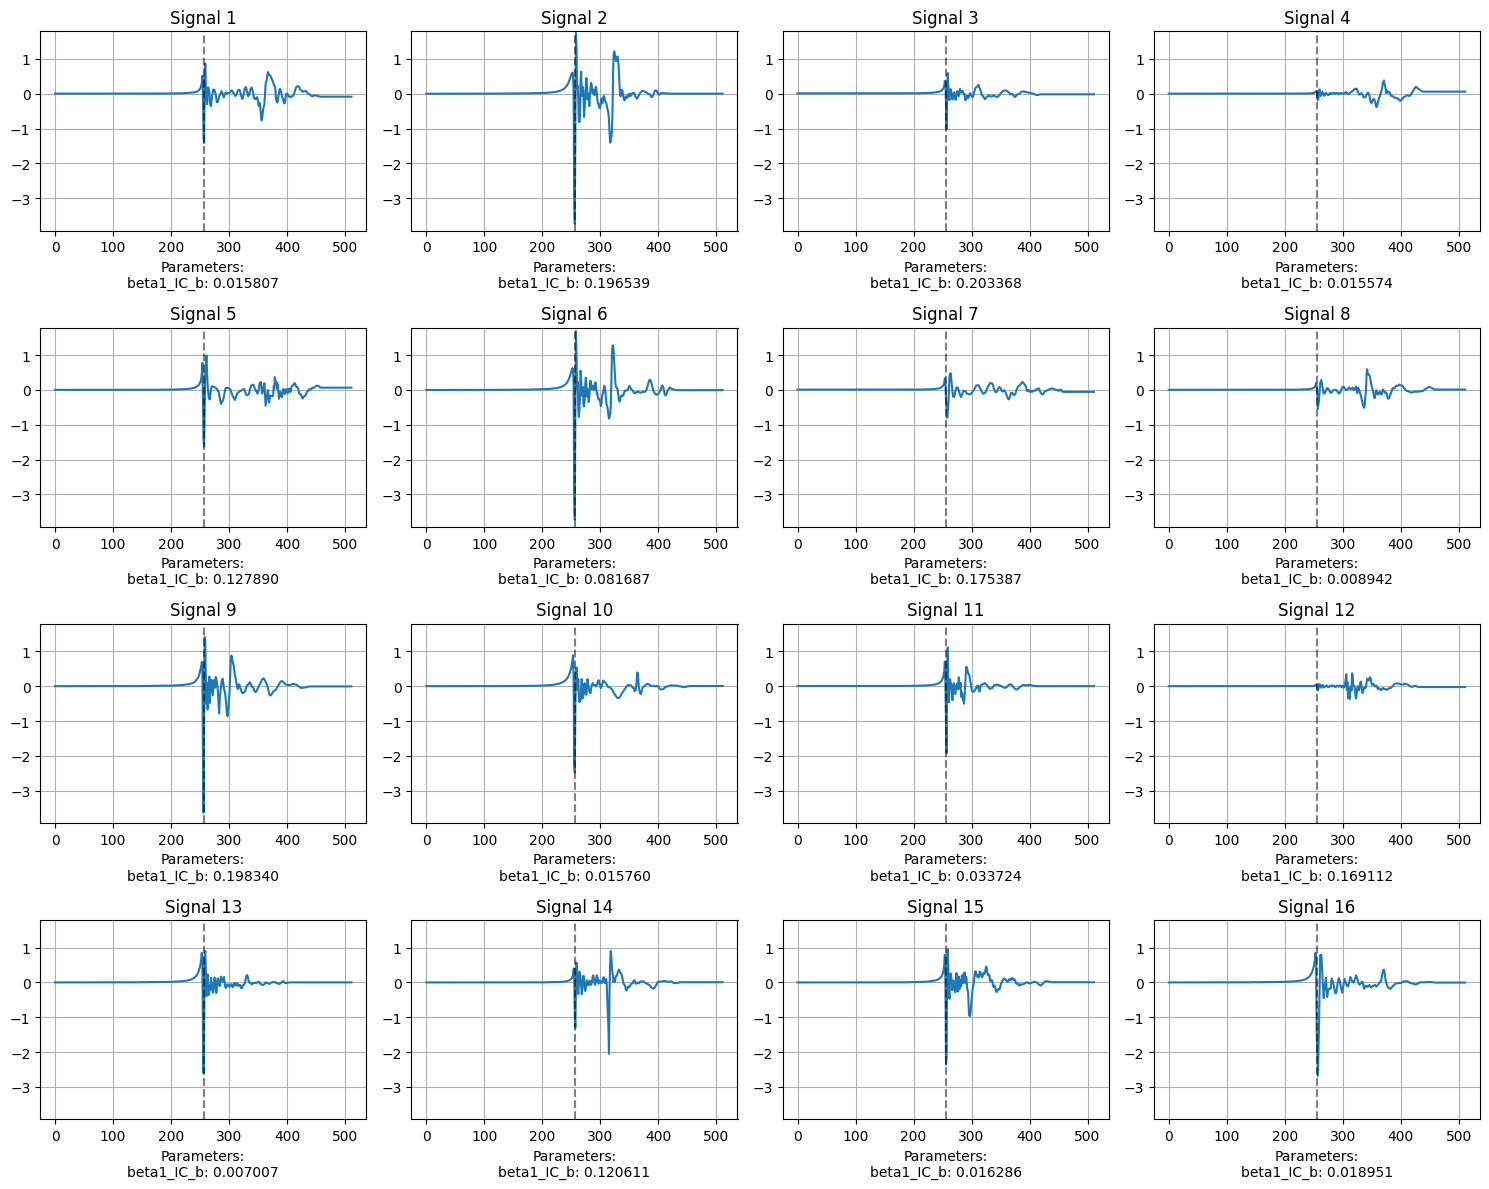

In [80]:
real_signals_batch, real_parameter_batch  = next(iter(train_loader))

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b']

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}'
        ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()
    
plot_waveforms(real_signals_batch, real_parameter_batch)

### Classifier Network